# Exploratory Data Analysis & Results Visualization

This notebook is used for two main purposes:
1.  **Exploring the Dataset**: Visually inspecting the high-quality and low-quality images to understand the challenges.
2.  **Analyzing Results**: Loading the saved evaluation metrics from the baseline and fine-tuned models to create comparison plots.

In [13]:
import os
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Add the src directory to the Python path to import our custom modules
sys.path.append(os.path.abspath(os.path.join('..')))

from src.config import DATA_DIR, DATA_SPLIT_FILE, OUTPUT_DIR
from src.utils import plot_metrics, plot_comparison_roc

--- 
## 1. Dataset Exploration

First, let's look at the dataset split to understand how our identities are divided between the training and evaluation sets.

In [14]:
try:
    with open(DATA_SPLIT_FILE, 'r') as f:
        split_data = json.load(f)
    
    train_identities = split_data['train']
    eval_idities = split_data['eval']
    
    print(f"Dataset Split Information")
    print(f"-------------------------")
    print(f"Total Training Identities: {len(train_identities)}")
    print(f"Total Evaluation Identities: {len(eval_idities)}")

except FileNotFoundError:
    print(f"Error: The data split file was not found at '{DATA_SPLIT_FILE}'.")
    print("Please run 'python scripts/1_prepare_dataset.py' first.")

Dataset Split Information
-------------------------
Total Training Identities: 6
Total Evaluation Identities: 2


### Visualizing High vs. Low-Quality Images

Now, let's randomly select an identity from the evaluation set and display one high-quality and one low-quality image to see the difference.

In [ ]:
def display_sample_images(identity):
    """Displays a sample high and low quality image for a given identity."""
    try:
        high_quality_path = os.path.join(DATA_DIR, identity, 'high_quality')
        low_quality_path = os.path.join(DATA_DIR, identity, 'low_quality')

        high_quality_img_name = random.choice(os.listdir(high_quality_path))
        low_quality_img_name = random.choice(os.listdir(low_quality_path))

        img_hq = cv2.imread(os.path.join(high_quality_path, high_quality_img_name))
        img_lq = cv2.imread(os.path.join(low_quality_path, low_quality_img_name))
        
        # Convert BGR to RGB for matplotlib
        img_hq_rgb = cv2.cvtColor(img_hq, cv2.COLOR_BGR2RGB)
        img_lq_rgb = cv2.cvtColor(img_lq, cv2.COLOR_BGR2RGB)
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        ax[0].imshow(img_hq_rgb)
        ax[0].set_title(f'High Quality - Identity: {identity}')
        ax[0].axis('off')
        
        ax[1].imshow(img_lq_rgb)
        ax[1].set_title(f'Low Quality - Identity: {identity}')
        ax[1].axis('off')
        
        plt.show()
        
    except (FileNotFoundError, IndexError) as e:
        print(f"Could not display images for identity '{identity}'. Make sure the directory structure is correct and contains images.")
        print(f"Error: {e}")

# Select a random identity from the evaluation set
if 'eval_idities' in locals() and eval_idities:
    sample_identity = random.choice(eval_idities)
    # display_sample_images(sample_identity)  #commended bcs, idont want to show img on github

--- 
## 2. Results Analysis and Visualization

In [16]:
# Define paths to the results files
baseline_results_path = os.path.join(OUTPUT_DIR, "baseline", "baseline_results.npz")
finetuned_results_path = os.path.join(OUTPUT_DIR, "fine_tuned", "finetuned_results.npz")

# Load baseline results
try:
    baseline_data = np.load(baseline_results_path)
    b_scores, b_gt = baseline_data['scores'], baseline_data['ground_truth']
    print("Successfully loaded baseline evaluation results.")
except FileNotFoundError:
    print(f"Baseline results not found at {baseline_results_path}. Please run 'scripts/2_run_baseline_eval.py'.")
    b_scores, b_gt = (None, None)

# Load fine-tuned results
try:
    finetuned_data = np.load(finetuned_results_path)
    ft_scores, ft_gt = finetuned_data['scores'], finetuned_data['ground_truth']
    print("Successfully loaded fine-tuned evaluation results.")
except FileNotFoundError:
    print(f"Fine-tuned results not found at {finetuned_results_path}. Please run 'scripts/4_run_final_eval.py'.")
    ft_scores, ft_gt = (None, None)

Successfully loaded baseline evaluation results.
Successfully loaded fine-tuned evaluation results.


### Similarity Score Distributions

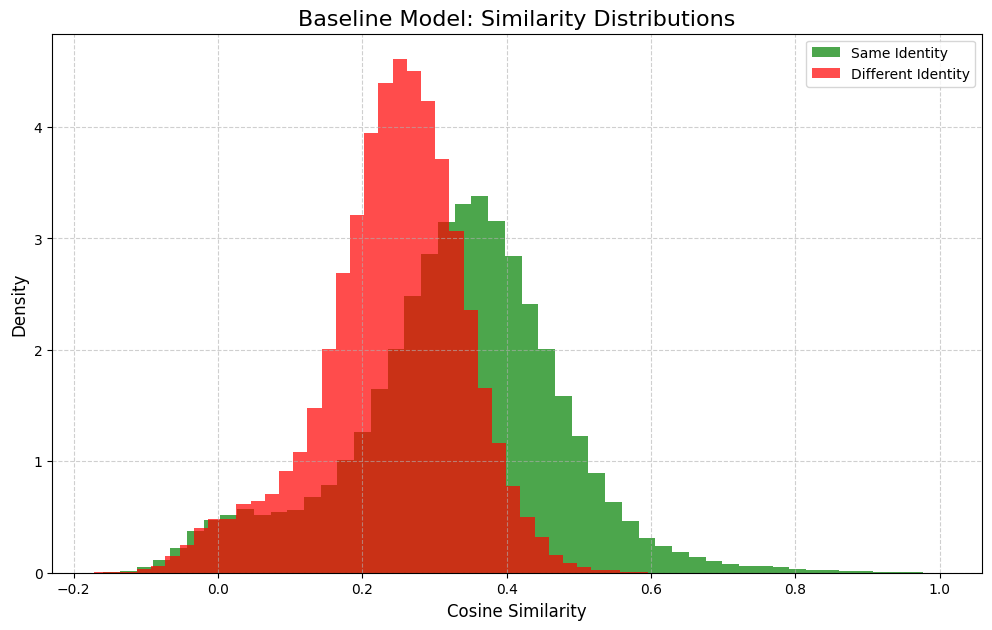

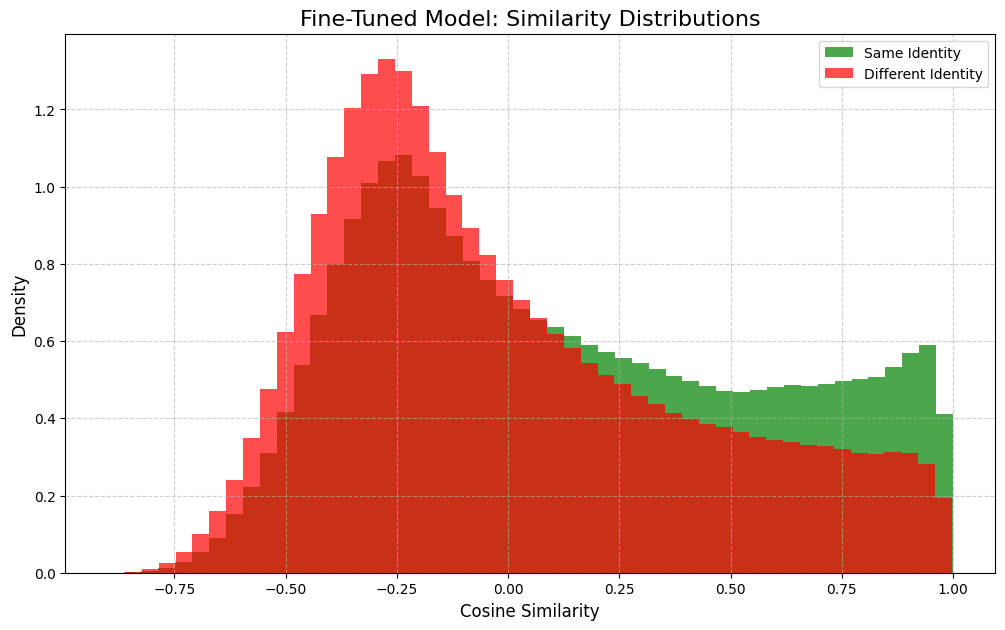

In [17]:
def plot_similarity_distribution(scores, ground_truth, title):
    same_scores = scores[ground_truth == 1]
    diff_scores = scores[ground_truth == 0]
    
    plt.figure(figsize=(12, 7))
    plt.hist(same_scores, bins=50, alpha=0.7, label='Same Identity', color='green', density=True)
    plt.hist(diff_scores, bins=50, alpha=0.7, label='Different Identity', color='red', density=True)
    plt.title(title, fontsize=16)
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

if b_scores is not None:
    plot_similarity_distribution(b_scores, b_gt, 'Baseline Model: Similarity Distributions')

if ft_scores is not None:
    plot_similarity_distribution(ft_scores, ft_gt, 'Fine-Tuned Model: Similarity Distributions')

### ROC Curve Comparison

Generating ROC Curve Comparison Plot...


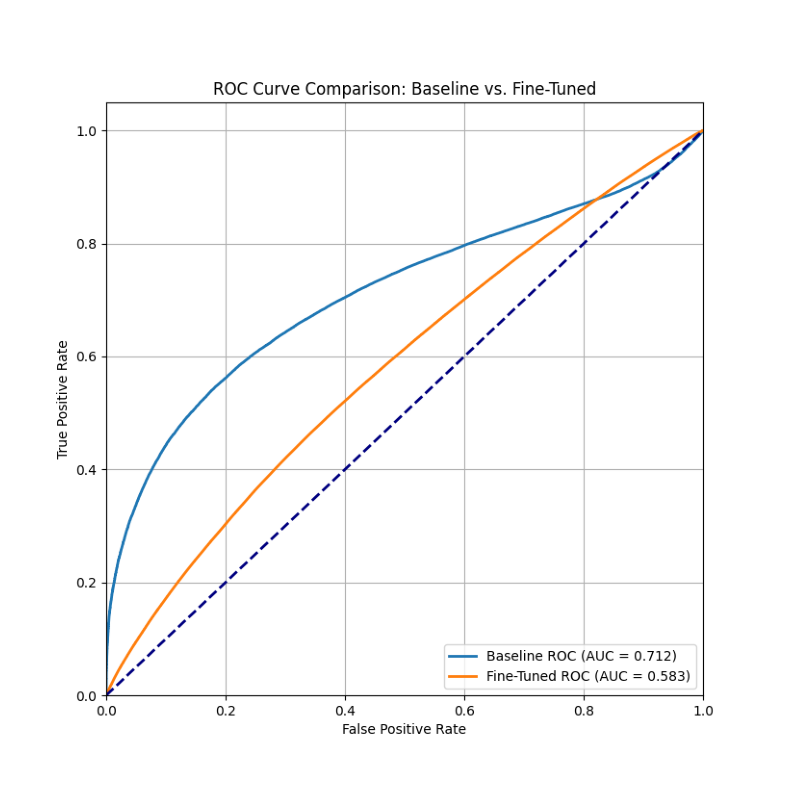

In [18]:
if (b_scores is not None) and (ft_scores is not None):
    print("Generating ROC Curve Comparison Plot...")
    baseline_results = (b_gt, b_scores)
    finetuned_results = (ft_gt, ft_scores)
    
    comparison_output_dir = os.path.join(OUTPUT_DIR, 'comparison_notebook')
    os.makedirs(comparison_output_dir, exist_ok=True)
        
    plot_comparison_roc(baseline_results, finetuned_results, comparison_output_dir)
    
    try:
        img = plt.imread(os.path.join(comparison_output_dir, 'comparison_roc_curve.png'))
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print("Plot image not found, but it should be saved in the outputs/comparison_notebook directory.")
else:
    print("Skipping comparison plot because one or both of the result sets were not loaded.")